In [ ]:
!pip3 install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc4,<2.1.0"
!mim install "mmdet>=3.0.0,<3.1.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.3.0
    Uninstalling platformdirs-3.3.0:
      Successfully uninstalled platformdirs-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pyp

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection3d.git -b dev-1.x
%cd mmdetection3d
!pip install -e .

Cloning into 'mmdetection3d'...
remote: Enumerating objects: 20528, done.
remote: Counting objects: 100% (1143/1143), done.
remote: Compressing objects: 100% (646/646), done.
remote: Total 20528 (delta 560), reused 907 (delta 491), pack-reused 19385
Receiving objects: 100% (20528/20528), 20.61 MiB | 29.40 MiB/s, done.
Resolving deltas: 100% (14223/14223), done.
/content/mmdetection3d
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmdetection3d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.5/681.5 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [ ]:
import mmdet3d
print(mmdet3d.__version__)

1.1.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from mmengine import load
from mmdet3d.apis import init_model, inference_detector
from mmdet3d.visualization import Det3DLocalVisualizer
from mmdet3d.structures import CameraInstance3DBoxes
import struct
from open3d import *
import mmcv

In [ ]:
info_file = load('/content/drive/MyDrive/188/kitti/kitti_infos_val.pkl')

ex_1_bin_file = '/content/drive/MyDrive/188/kitti/training/velodyne_reduced/002788.bin'
ex_1_img_file = '/content/drive/MyDrive/188/kitti/training/image_2/002788.png'
ex_1_calib_file = '/content/drive/MyDrive/188/kitti/training/calib/002788.txt'
ex_1_index = 6

ex_2_bin_file = '/content/drive/MyDrive/188/kitti/training/velodyne_reduced/001191.bin'
ex_2_img_file = '/content/drive/MyDrive/188/kitti/training/image_2/001191.png'
ex_2_calib_file = '/content/drive/MyDrive/188/kitti/training/calib/001191.txt'
ex_2_index = 123

## Helpers

In [ ]:
# Load calibration file to convert from LIDAR to image coordinates
def load_calib(calib_file):
    with open(calib_file, 'r') as f:
        lines = f.readlines()
    calib = {}
    for line in lines:
        line = line.strip()
        if len(line) == 0: continue
        key, value = line.split(':', 1)
        calib[key] = np.array([float(x) for x in value.split()])
    return calib

# Visualize and return image with 3D bounding boxes. Threshold can be provided for score.
def visualize_predict_3d(index, prediction, img_file, calib_file, threshold=0.5):
  # Metadata information required
  calib = load_calib(calib_file)
  cam2img = np.array(info_file['data_list'][index]['images']['CAM2']['cam2img'], dtype=np.float32)

  # Create camera boxes based on LIDAR predictions
  boxes = []

  for instance in prediction.pred_instances_3d:
    if instance.scores_3d[0] > threshold:
      boxes.append(instance.bboxes_3d.tensor)

  lidar_boxes_tensor = torch.cat(boxes).to('cpu')
  Tr_velo_to_cam = calib["Tr_velo_to_cam"].reshape(3, 4)

  # Add extra dimension to the box centers for transformation to image coordinates
  centers = lidar_boxes_tensor[:, :3]
  centers_hom = np.concatenate([centers, np.ones((centers.shape[0], 1))], axis=-1)
  camera_centers_hom = centers_hom @ Tr_velo_to_cam.T

  # All other parameters except coordinates can be copied over
  extras = lidar_boxes_tensor[:, 3:].clone()

  # Based on MMDetection API, the yaw is defined differently than normal.
  yaw = extras[:, -1]
  yaw_cam = -yaw - np.pi / 2

  # Construct the boxes tensor in camera coordinates
  camera_boxes_tensor = torch.cat([torch.from_numpy(camera_centers_hom), extras[:, :-1], yaw_cam[:, None]], dim=-1)
  camera_boxes = CameraInstance3DBoxes(camera_boxes_tensor)
  input_meta = {'cam2img': cam2img}

  # Visualize and return image
  visualizer = Det3DLocalVisualizer(save_dir='temp_dir')
  img = mmcv.imread(img_file)
  img = mmcv.imconvert(img, 'bgr', 'rgb')
  visualizer.set_image(img)
  visualizer.draw_proj_bboxes_3d(camera_boxes, input_meta)

  final_img = visualizer.get_image()
  return mmcv.imconvert(final_img, 'rgb', 'bgr')

In [ ]:
# Visualize and return ground truth image and 3D bounding boxes.
def visualize_gt_3d(index, img_file):
  cam2img = np.array(info_file['data_list'][index]['images']['CAM2']['cam2img'], dtype=np.float32)

  bboxes_3d = []

  for instance in info_file['data_list'][index]['instances']:
    print(instance['bbox_3d'])
    bboxes_3d.append(instance['bbox_3d'])

  gt_bboxes_3d = np.array(bboxes_3d, dtype=np.float32)
  gt_bboxes_3d = CameraInstance3DBoxes(gt_bboxes_3d)
  input_meta = {'cam2img': cam2img}
  print(gt_bboxes_3d)

  visualizer = Det3DLocalVisualizer(save_dir='temp_dir')

  img = mmcv.imread(img_file)
  img = mmcv.imconvert(img, 'bgr', 'rgb')
  visualizer.set_image(img)

  visualizer.draw_proj_bboxes_3d(gt_bboxes_3d, input_meta)
  final_img = visualizer.get_image()
  return mmcv.imconvert(final_img, 'rgb', 'bgr')

## PV-RCNN

In [ ]:
config_file = '/content/mmdetection3d/configs/pv_rcnn/pv_rcnn_8xb2-80e_kitti-3d-3class.py'
checkpoint_file = '/content/drive/MyDrive/188/custom_pv_rcnn.pth'

pv_detector = init_model(config_file, checkpoint_file, device='cuda:0')

/content/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /content/drive/MyDrive/188/custom_pv_rcnn.pth


In [ ]:
results_1, _ = inference_detector(pv_detector, ex_1_bin_file)
results_2, _ = inference_detector(pv_detector, ex_2_bin_file)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Example 1

[8.53, 1.2, 75.83, 23.29, 3.33, 2.37, -1.6]
[-9.05, 2.03, 12.57, 4.31, 1.75, 1.71, 1.57]
[-8.77, 1.97, 22.25, 4.01, 1.53, 1.66, 1.57]
[-8.61, 1.98, 27.47, 3.9, 1.48, 1.6, 1.6]
[-8.18, 2.0, 47.32, 4.56, 1.61, 1.67, 1.6]
[11.82, 1.05, 35.15, 1.7, 1.78, 0.44, -1.57]
[-1000.0, -1000.0, -1000.0, -1.0, -1.0, -1.0, -10.0]
[-1000.0, -1000.0, -1000.0, -1.0, -1.0, -1.0, -10.0]
CameraInstance3DBoxes(
    tensor([[ 8.5300e+00,  1.2000e+00,  7.5830e+01,  2.3290e+01,  3.3300e+00,
          2.3700e+00, -1.6000e+00],
        [-9.0500e+00,  2.0300e+00,  1.2570e+01,  4.3100e+00,  1.7500e+00,
          1.7100e+00,  1.5700e+00],
        [-8.7700e+00,  1.9700e+00,  2.2250e+01,  4.0100e+00,  1.5300e+00,
          1.6600e+00,  1.5700e+00],
        [-8.6100e+00,  1.9800e+00,  2.7470e+01,  3.9000e+00,  1.4800e+00,
          1.6000e+00,  1.6000e+00],
        [-8.1800e+00,  2.0000e+00,  4.7320e+01,  4.5600e+00,  1.6100e+00,
          1.6700e+00,  1.6000e+00],
        [ 1.1820e+01,  1.0500e+00,  3.5150e+01,  1.70

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


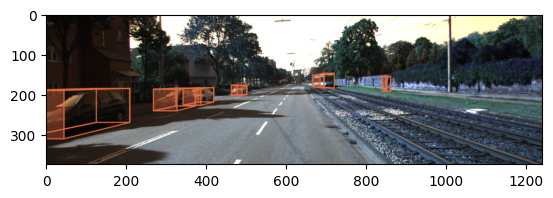

In [ ]:
ground = visualize_gt_3d(ex_1_index, ex_1_img_file)
plt.imshow(ground)

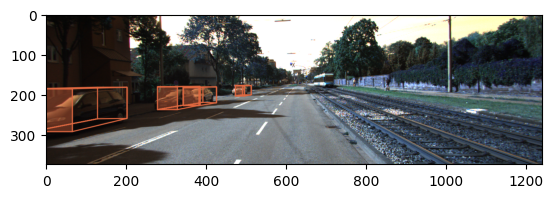

In [ ]:
# Threshold = 0.5
pred = visualize_predict_3d(ex_1_index, results_1, ex_1_img_file, ex_1_calib_file)
plt.imshow(pred)

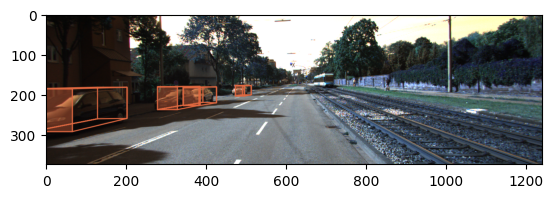

In [ ]:
# Threshold = 0.7
pred = visualize_predict_3d(ex_1_index, results_1, ex_1_img_file, ex_1_calib_file, threshold=0.7)
plt.imshow(pred)

### Example 2

[-4.81, 1.45, 8.55, 1.02, 1.87, 0.54, -3.12]
CameraInstance3DBoxes(
    tensor([[-4.8100,  1.4500,  8.5500,  1.0200,  1.8700,  0.5400, -3.1200]]))


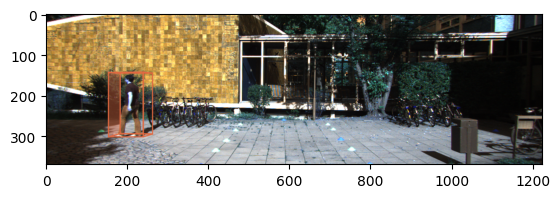

In [ ]:
ground = visualize_gt_3d(ex_2_index, ex_2_img_file)
plt.imshow(ground)

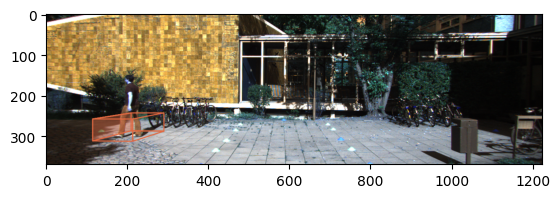

In [ ]:
# Threshold = 0.5
pred = visualize_predict_3d(ex_2_index, results_2, ex_2_img_file, ex_2_calib_file)
plt.imshow(pred)

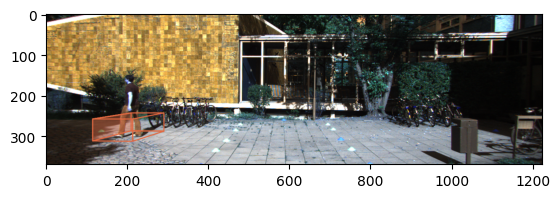

In [ ]:
# Threshold = 0.7
pred = visualize_predict_3d(ex_2_index, results_2, ex_2_img_file, ex_2_calib_file, threshold=0.7)
plt.imshow(pred)

## PointPillar

In [ ]:
config_file = '/content/mmdetection3d/configs/pointpillars/pointpillars_hv_secfpn_8xb6-160e_kitti-3d-3class.py'
checkpoint_file = '/content/drive/MyDrive/188/custom_point_pillars.pth'

pp_detector = init_model(config_file, checkpoint_file, device='cuda:0')

/content/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /content/drive/MyDrive/188/custom_point_pillars.pth


In [ ]:
results_1, _ = inference_detector(pp_detector, ex_1_bin_file)
results_2, _ = inference_detector(pp_detector, ex_2_bin_file)

### Example 1

[8.53, 1.2, 75.83, 23.29, 3.33, 2.37, -1.6]
[-9.05, 2.03, 12.57, 4.31, 1.75, 1.71, 1.57]
[-8.77, 1.97, 22.25, 4.01, 1.53, 1.66, 1.57]
[-8.61, 1.98, 27.47, 3.9, 1.48, 1.6, 1.6]
[-8.18, 2.0, 47.32, 4.56, 1.61, 1.67, 1.6]
[11.82, 1.05, 35.15, 1.7, 1.78, 0.44, -1.57]
[-1000.0, -1000.0, -1000.0, -1.0, -1.0, -1.0, -10.0]
[-1000.0, -1000.0, -1000.0, -1.0, -1.0, -1.0, -10.0]
CameraInstance3DBoxes(
    tensor([[ 8.5300e+00,  1.2000e+00,  7.5830e+01,  2.3290e+01,  3.3300e+00,
          2.3700e+00, -1.6000e+00],
        [-9.0500e+00,  2.0300e+00,  1.2570e+01,  4.3100e+00,  1.7500e+00,
          1.7100e+00,  1.5700e+00],
        [-8.7700e+00,  1.9700e+00,  2.2250e+01,  4.0100e+00,  1.5300e+00,
          1.6600e+00,  1.5700e+00],
        [-8.6100e+00,  1.9800e+00,  2.7470e+01,  3.9000e+00,  1.4800e+00,
          1.6000e+00,  1.6000e+00],
        [-8.1800e+00,  2.0000e+00,  4.7320e+01,  4.5600e+00,  1.6100e+00,
          1.6700e+00,  1.6000e+00],
        [ 1.1820e+01,  1.0500e+00,  3.5150e+01,  1.70

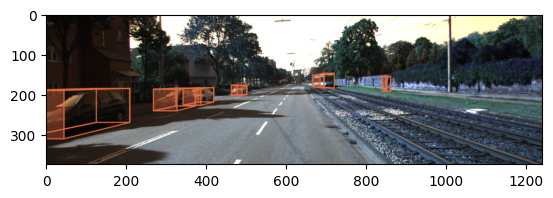

In [ ]:
ground = visualize_gt_3d(ex_1_index, ex_1_img_file)
plt.imshow(ground)

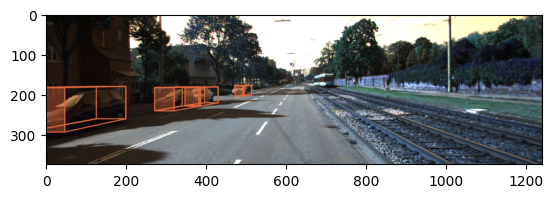

In [ ]:
# Threshold = 0.5
pred = visualize_predict_3d(ex_1_index, results_1, ex_1_img_file, ex_1_calib_file)
plt.imshow(pred)

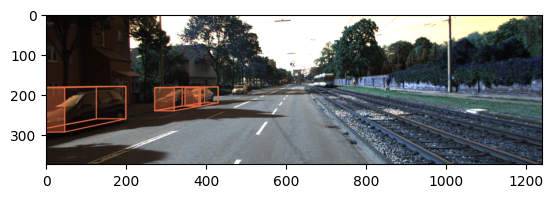

In [ ]:
# Threshold = 0.7
pred = visualize_predict_3d(ex_1_index, results_1, ex_1_img_file, ex_1_calib_file, threshold = 0.7)
plt.imshow(pred)

### Example 2

[-4.81, 1.45, 8.55, 1.02, 1.87, 0.54, -3.12]
CameraInstance3DBoxes(
    tensor([[-4.8100,  1.4500,  8.5500,  1.0200,  1.8700,  0.5400, -3.1200]]))


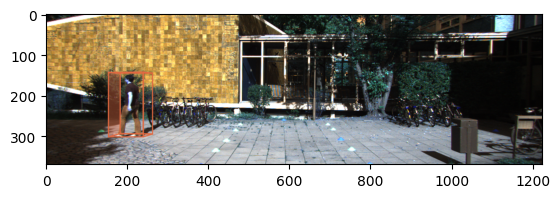

In [ ]:
ground = visualize_gt_3d(ex_2_index, ex_2_img_file)
plt.imshow(ground)

In [ ]:
# Threshold = 0.5
pred = visualize_predict_3d(ex_2_index, results_2, ex_2_img_file, ex_2_calib_file)
plt.imshow(pred)

RuntimeError: ignored

In [ ]:
# Threshold = 0.7
pred = visualize_predict_3d(ex_2_index, results_2, ex_2_img_file, ex_2_calib_file, threshold = 0.7)
plt.imshow(pred)

RuntimeError: ignored